In [1]:
import os
import numpy as np

try:
    os.makedirs("fake_files")
except:
    pass
else:
    for idx in range(15_000):
        fname = "fake_files/file_{}.npy".format(idx)
        if not os.path.exists(fname):
            np.save(fname, np.random.normal(size=100000))  
        else:
            print(idx)

# HPC con Python

### Algunas herramientas de optimización de alto nivel en python

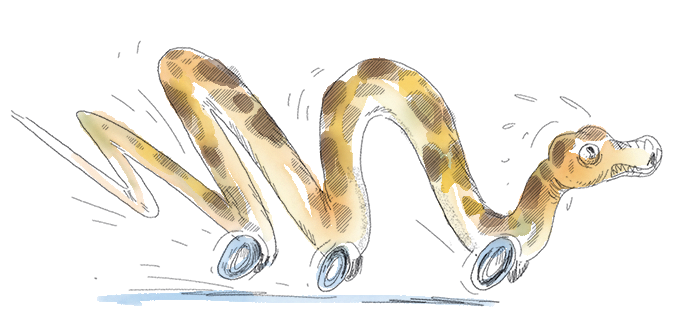

## Memoization

- La memoización es una técnica de optimización utilizada en programación y computación para mejorar el rendimiento de algoritmos, especialmente en casos donde se realizan cálculos costosos y recurrentes. 
- El principio fundamental de la memoización es almacenar en memoria caché (memoria temporal) los resultados de cálculos anteriores para que, cuando se requieran nuevamente con los mismos parámetros de entrada, se puedan recuperar desde la memoria caché en lugar de volver a calcularlos.

In [2]:
import time

def calculo_lento(x):
    time.sleep(3)
    return x ** 2

In [5]:
%%time
calculo_lento(2)

CPU times: user 1.74 ms, sys: 0 ns, total: 1.74 ms
Wall time: 3.01 s


4

## Memoization en memoria

Esto no es util para resultados y entradas grandes por que te explota el RAM

In [12]:
import functools

calculo_lento = functools.cache(calculo_lente)

In [10]:
%%time
calculo_lento(20)

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 7.15 µs


400

## Memoization

decorar la función al momento de la creación

In [16]:
cache = {}
def calculo_lento(x):
    if x not in cache:
        time.sleep(3)
        cache[x] = x ** 2
    return cache[x]

In [13]:
import functools
import time

@functools.cache
def calculo_lento(x):
    time.sleep(3)
    return x ** 2

In [22]:
%%time
cache

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


{2: 4, 3: 9}

## Problema

In [30]:
%%time
import numpy as np
import joblib

def open_file(idx):
    fname = "fake_files/file_{}.npy".format(idx)
    with open(fname, "rb") as fp:
        nums = np.load(fp)
    return nums

with joblib.Parallel() as P:
    open_file_d = joblib.delayed(open_file)
    queue = (open_file_d(idx) for idx in range(500))
    results = P(queue)

CPU times: user 84.8 ms, sys: 183 ms, total: 268 ms
Wall time: 267 ms


## Joblib

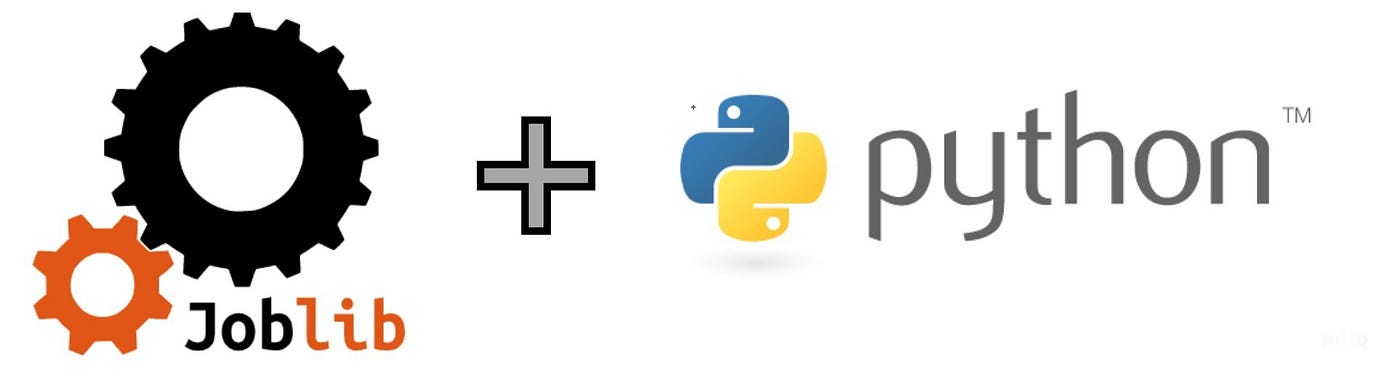

Ayudante simple para facilitar la escritura de código paralelo legible y depurarlo rápidamente.

```bash
$ pip install joblib
$ conda install joblib
```

## Joblib - Multiprocessing

In [31]:
%%time
import numpy as np
import joblib # import Parallel, delayed

def open_file(idx):
    fname = "fake_files/file_{}.npy".format(idx)
    with open(fname, "rb") as fp:
        nums = np.load(fp)
    return nums


with joblib.Parallel(n_jobs=-1, backend="loky") as parallel:
    delayed_open_file = joblib.delayed(open_file)  # una decoracion
    
    queue = (delayed_open_file(idx) for idx in range(5000))
    
    results = parallel(queue) 

CPU times: user 2.57 s, sys: 3.69 s, total: 6.26 s
Wall time: 6.69 s


## Joblib - Comunicación de procesos

Como hay varios backends y la idea es ser genérico para todos, `joblib` no brinda mecanismos de comunicación ni de sincronización portables entre backends. En lugar de eso, propone usar `numpy.memmap`, que es un array en disco.


In [33]:
def open_file(idx, means):
    fname = "fake_files/file_{}.npy".format(idx)
    with open(fname, "rb") as fp:
        nums = np.load(fp)
    means[idx] = np.mean(nums)
    return nums

In [34]:
means = np.memmap("archivo.mm", mode="w+", dtype=float, shape=5000)

with joblib.Parallel(n_jobs=-1, backend="loky") as parallel:
    delayed_open_file = joblib.delayed(open_file)  # una decoracion
    results = parallel(
        delayed_open_file(idx, means) 
        for idx in range(5000)
    )

In [35]:
means

memmap([-0.00238283,  0.00066254,  0.00398775, ...,  0.00048522,
         0.00108556,  0.00267975])

## Joblib - Multi-Threading

In [ ]:
%%time

import joblib # import Parallel, delayed

def open_file(idx):
    fname = "fake_files/file_{}.npy".format(idx)
    with open(fname, "rb") as fp:
        nums = np.load(fp)
    return nums


with joblib.Parallel(n_jobs=1, backend="threading") as parallel:
    results = parallel(
        joblib.delayed(open_file)(idx) for idx in range(5000))

## Joblib - Memoization en disco!

Útil para datos grandes! (pero te aumenta el I/O) 🎃

In [36]:
from joblib import Memory
mem = Memory("mi_cache")

@mem.cache
def calculo_lento(x):
    time.sleep(3)
    return x ** 2

In [38]:
%time calculo_lento(2)

CPU times: user 458 µs, sys: 576 µs, total: 1.03 ms
Wall time: 995 µs


4

In [43]:
joblib.dump(1, "archivo.jb")

1

In [39]:
!ls mi_cache/joblib

__main__--tmp-ipykernel-3768585022


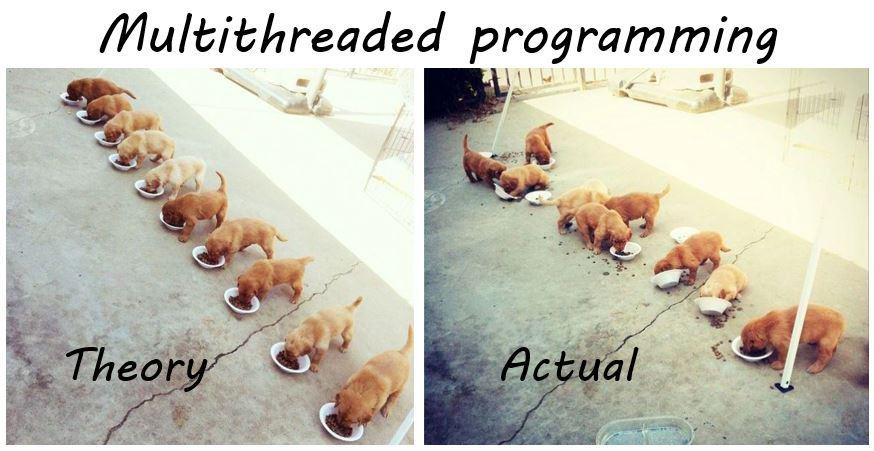